In [45]:
import math
import requests_cache
import numpy as np
import pandas as pd
import sympy as sy
import datetime as dt
from scipy.stats import norm
import scipy.stats as si
import matplotlib.pyplot as plt

from copy import deepcopy
from pandas_datareader.data import DataReader
from pypfopt.discrete_allocation import DiscreteAllocation


In [43]:
from ipynb.fs.full.constants import TICKERS_CRYPTO_USD_PAIRS, TICKERS_COUNTS_STOCKS_NYSE, START_DATE_ANALYSIS, END_DATE_ANALYSIS
from ipynb.fs.full.data_retriever import get_log_returns_from_yahoo, get_prices_from_yahoo, get_all_returns_from_yahoo

In [3]:
TICKERS_CRYPTO_USD_PAIRS

['BTC-USD', 'ETH-USD', 'DOT1-USD']

### CONSTANTS

In [4]:
session = requests_cache.CachedSession(cache_name='cache', backend='sqlite')

# just add headers to your session and provide it to the reader
session.headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:89.0) Gecko/20100101 Firefox/89.0',
                   'Accept': 'application/json;charset=utf-8'}

### RETRIEVING PRICES AND RETURNS

In [5]:
df_prices = get_prices_from_yahoo(TICKERS_CRYPTO_USD_PAIRS, START_DATE_ANALYSIS, END_DATE_ANALYSIS, session)

In [6]:
df_prices

,BTC-USD,ETH-USD,DOT1-USD
Date,,,
2020-05-01,8864.766602,214.219101,0.000000
2020-05-02,8988.596680,215.325378,0.000000
2020-05-03,8897.468750,210.933151,0.000000
2020-05-04,8912.654297,208.174011,0.000000
2020-05-05,9003.070312,206.774399,0.000000
...,...,...,...
2021-11-27,54815.078125,4096.912109,35.186699
2021-11-28,57248.457031,4294.453613,35.765121
2021-11-29,57806.566406,4445.104980,37.162655


In [7]:
df_log_returns = get_log_returns_from_yahoo(TICKERS_CRYPTO_USD_PAIRS, 
                                            START_DATE_ANALYSIS, END_DATE_ANALYSIS, session)

In [34]:
df_log_returns.tail()

,BTC-USD,ETH-USD,DOT1-USD
Date,,,
2021-11-27,0.022980,0.016242,0.023021
2021-11-28,0.043435,0.047091,0.016305
2021-11-29,0.009702,0.034479,0.038331
2021-11-30,-0.013956,0.041073,0.021242
2021-12-01,0.003929,-0.009652,-0.031775


In [51]:
def historical_sim_var_es(market_values_df, target_log_returns_list, target_coin,
                          no_days_analysis, var_alpha= 0.05):
    market_values_hs = deepcopy(market_values_df.reset_index())
    target_coin_name = target_coin.split("-")[0]
    
    # For each row, use previous no_days_analysis rows' (return series) to calculate VaR.
    for i in range(0, len(market_values_hs)):
        for target in target_log_returns_list:
            past_values = market_values_hs.loc[(i-(no_days_analysis-1)):(i), target]
            past_values.dropna(inplace=True)  
            
            target_name = target.split("-")[0]

            if len(past_values) == no_days_analysis:
                var = past_values.quantile(var_alpha)  
                market_values_hs.loc[i, 'VaR'] = var # VaR 95% in log returns
                market_values_hs.loc[i, (target_name+'_VaR_perc')] = np.exp(var)-1 # in terms of %

                log_returns_sorted = sorted(past_values.dropna())
                length = len(log_returns_sorted)
                cutoff_rt_index = math.floor(length*var_alpha +1) - 1

                sum_rt = sum(log_returns_sorted[:cutoff_rt_index])
                
                # getting correlation/covariance of current coin's log returns with target coin's log returns
                # only if it is not the same coin
                if target != target_coin:
                    # get correlation
                    market_values_hs.loc[i, (f'{target_name}_{target_coin_name}_corr'
                                            )] = market_values_hs.loc[(i - (no_days_analysis - 1)):(i), 
                                                                      [target, target_coin]].corr()[target][target_coin]
                    # get covariance
                    market_values_hs.loc[i, (f'{target_name}_{target_coin_name}_cov'
                                            )] = market_values_hs.loc[(i - (no_days_analysis - 1)):(i), 
                                                                      [target, target_coin]].cov()[target][target_coin]
                    
                market_values_hs.loc[i, 'sum_log'] = sum_rt
                market_values_hs.loc[i, 'ES'] = sum_rt/len(log_returns_sorted[:cutoff_rt_index])
                market_values_hs.loc[i, (target_name+'_ES_perc')] = np.exp(market_values_hs.loc[i, 'ES'])-1 # in terms of %
                market_values_hs = market_values_hs.drop(["VaR", "ES", "sum_log"],axis=1) #"sum_log_95"
                
            else:
                market_values_hs.loc[i, 'VaR'], market_values_hs.loc[i, (target_name+'_VaR_perc')]= np.NaN, np.NaN
                market_values_hs.loc[i, 'ES'], market_values_hs.loc[i, (target_name+'_ES_perc')] = np.NaN, np.NaN
                market_values_hs.loc[i, (f'{target_name}_{target_coin_name}_corr')] = np.NaN
                market_values_hs.loc[i, (f'{target_name}_{target_coin_name}_cov')] = np.NaN
                
                market_values_hs = market_values_hs.drop(["VaR", "ES"],axis=1) #"sum_log_95"

    market_values_hs = market_values_hs.drop([f'{target_coin_name}_{target_coin_name}_corr',
                                              f'{target_coin_name}_{target_coin_name}_cov'] , axis=1)
    
    return market_values_hs

In [52]:
df_log_returns.corr()

,BTC-USD,ETH-USD,DOT1-USD
BTC-USD,1.000000,0.761275,0.570072
ETH-USD,0.761275,1.000000,0.635077
DOT1-USD,0.570072,0.635077,1.000000


In [53]:
df_log_returns.cov()

,BTC-USD,ETH-USD,DOT1-USD
BTC-USD,0.001392,0.001437,0.001462
ETH-USD,0.001437,0.002559,0.002207
DOT1-USD,0.001462,0.002207,0.004722


In [60]:
df = historical_sim_var_es(df_log_returns, ["BTC-USD", "ETH-USD", "DOT1-USD"], "DOT1-USD", 60, var_alpha= 0.05)

In [61]:
df.tail()

,Date,BTC-USD,ETH-USD,DOT1-USD,BTC_VaR_perc,BTC_ES_perc,BTC_DOT1_corr,BTC_DOT1_cov,ETH_VaR_perc,ETH_ES_perc,ETH_DOT1_corr,ETH_DOT1_cov,DOT1_VaR_perc,DOT1_ES_perc
572,2021-11-27,0.022980,0.016242,0.023021,-0.053607,-0.059592,0.587227,0.001065,-0.049041,-0.066301,0.685259,0.001354,-0.084843,-0.097124
573,2021-11-28,0.043435,0.047091,0.016305,-0.053607,-0.059592,0.584348,0.001069,-0.049041,-0.066301,0.681666,0.001357,-0.084843,-0.097124
574,2021-11-29,0.009702,0.034479,0.038331,-0.053607,-0.059592,0.577877,0.001037,-0.049041,-0.066301,0.680046,0.001341,-0.084843,-0.097124
575,2021-11-30,-0.013956,0.041073,0.021242,-0.053607,-0.059592,0.532337,0.000866,-0.049041,-0.066301,0.651459,0.001184,-0.084843,-0.097124
576,2021-12-01,0.003929,-0.009652,-0.031775,-0.053607,-0.059592,0.530897,0.000866,-0.049041,-0.066301,0.654217,0.001192,-0.084843,-0.097124


## GRAPHS

### VaR

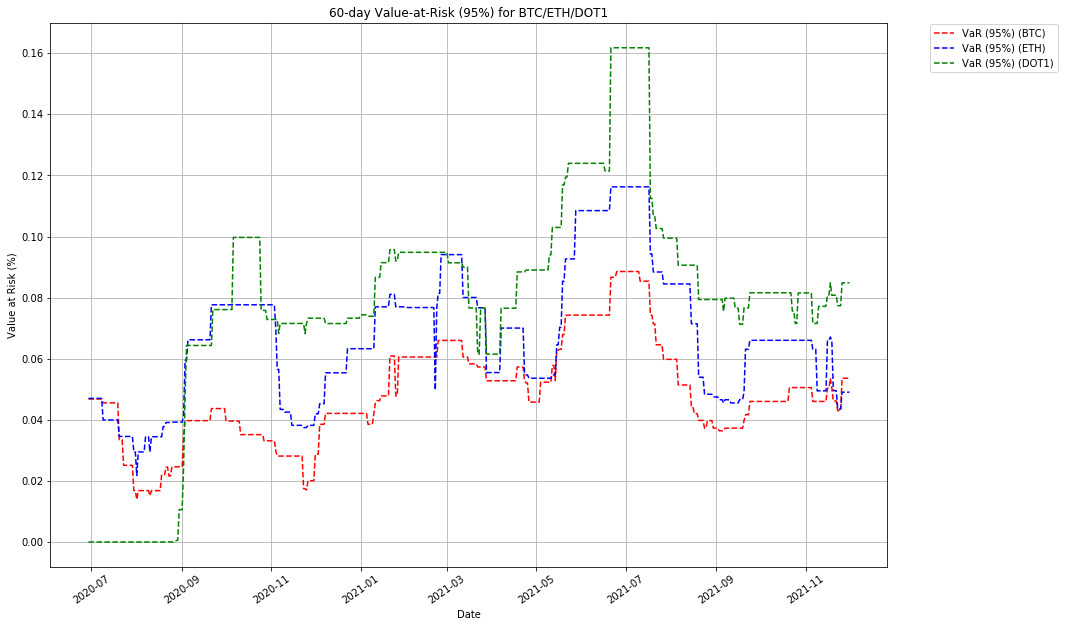

In [62]:
# Plot VaR_95
plt.figure(figsize=(15,10))
plt.plot(df['Date'], -df['BTC_VaR_perc'], 'r--', label='VaR (95%) (BTC)')
plt.plot(df['Date'], -df['ETH_VaR_perc'], 'b--', label='VaR (95%) (ETH)')
plt.plot(df['Date'], -df['DOT1_VaR_perc'], 'g--', label='VaR (95%) (DOT1)')

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Value at Risk (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
locs, labels = plt.xticks()
plt.setp(labels, rotation=35)
plt.title('60-day Value-at-Risk (95%) for BTC/ETH/DOT1')
plt.savefig('var_fintech_btc_eth_dot1.jpg', bbox_inches='tight')
plt.show()

### Expected Shortfall

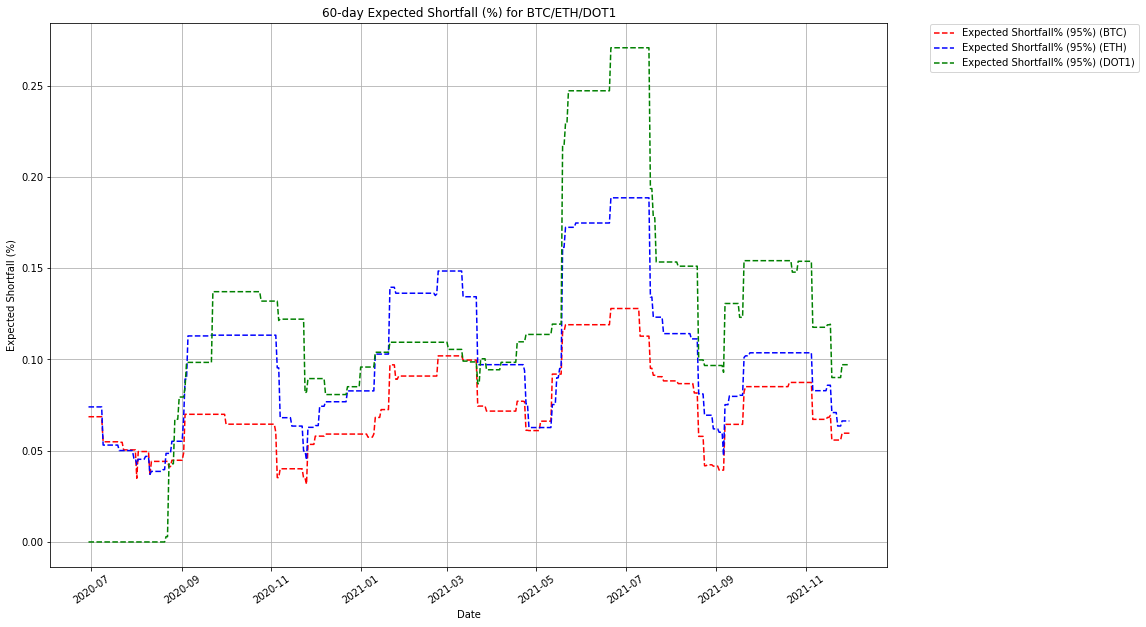

In [63]:
plt.figure(figsize=(15,10))
plt.plot(df['Date'], -df['BTC_ES_perc'], 'r--', label='Expected Shortfall% (95%) (BTC)')
plt.plot(df['Date'], -df['ETH_ES_perc'], 'b--', label='Expected Shortfall% (95%) (ETH)')
plt.plot(df['Date'], -df['DOT1_ES_perc'], 'g--', label='Expected Shortfall% (95%) (DOT1)')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Expected Shortfall (%)')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
locs, labels = plt.xticks()
plt.setp(labels, rotation=35)
plt.title('60-day Expected Shortfall (%) for BTC/ETH/DOT1')
plt.savefig('es_fintech_btc_eth_dot1.jpg', bbox_inches='tight')
plt.show()

### Correlation

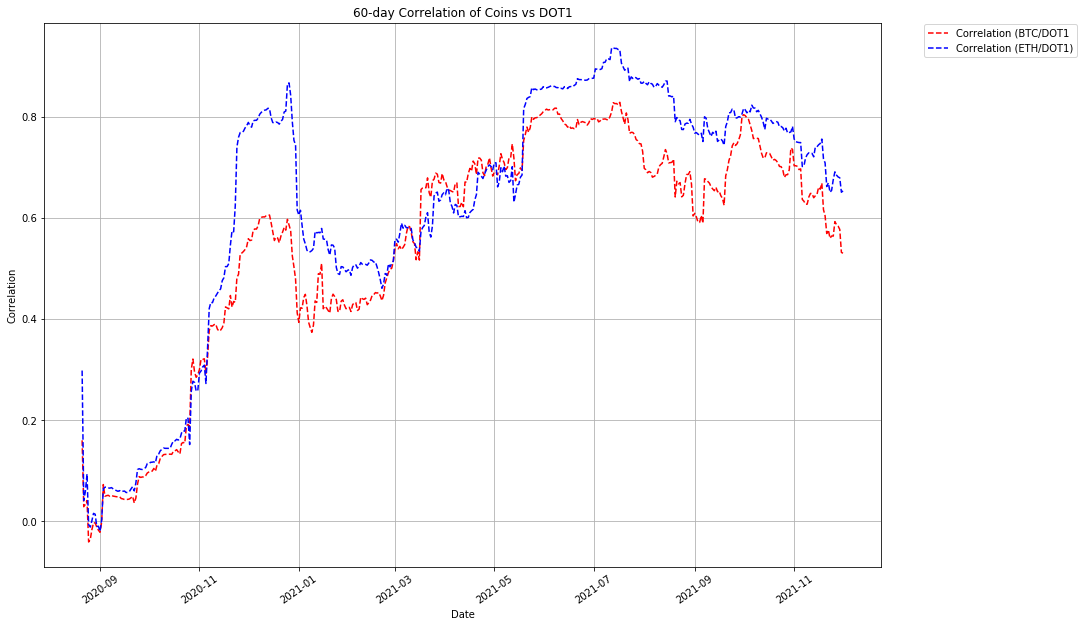

In [64]:
plt.figure(figsize=(15,10))
plt.plot(df['Date'], df['BTC_DOT1_corr'], 'r--', label='Correlation (BTC/DOT1')
plt.plot(df['Date'], df['ETH_DOT1_corr'], 'b--', label='Correlation (ETH/DOT1)')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Correlation')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
locs, labels = plt.xticks()
plt.setp(labels, rotation=35)
plt.title('60-day Correlation of Coins vs DOT1')
plt.savefig('corr_fintech_btc_eth_dot1.jpg', bbox_inches='tight')
plt.show()

### Covariance

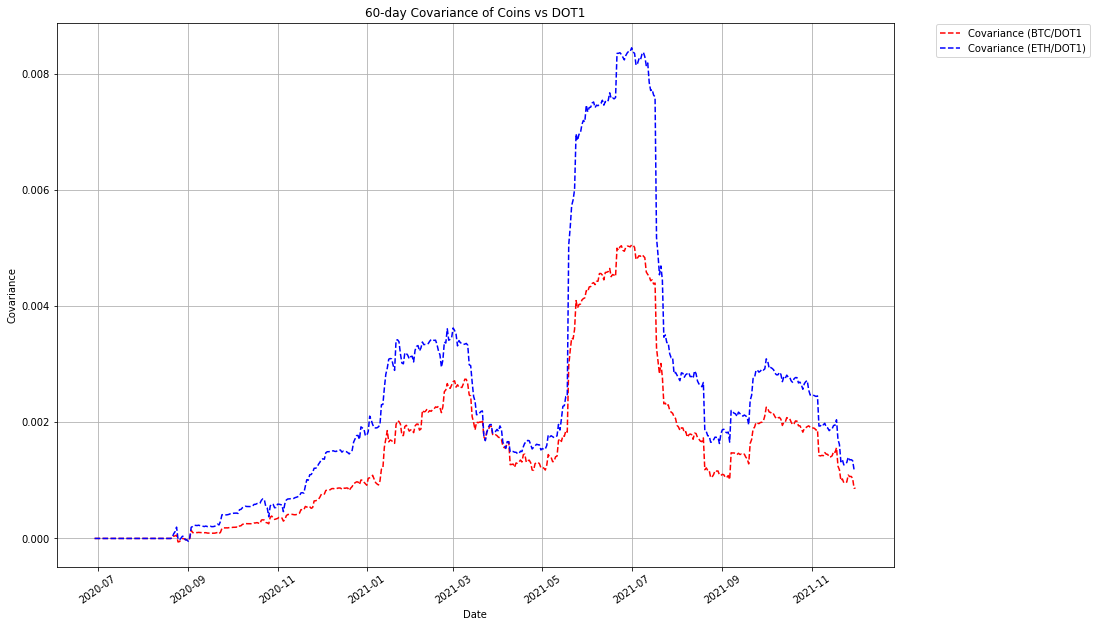

In [65]:
plt.figure(figsize=(15,10))
plt.plot(df['Date'], df['BTC_DOT1_cov'], 'r--', label='Covariance (BTC/DOT1')
plt.plot(df['Date'], df['ETH_DOT1_cov'], 'b--', label='Covariance (ETH/DOT1)')
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Covariance')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.1)
locs, labels = plt.xticks()
plt.setp(labels, rotation=35)
plt.title('60-day Covariance of Coins vs DOT1')
plt.savefig('cov_fintech_btc_eth_dot1.jpg', bbox_inches='tight')
plt.show()